In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Data Prep

## Create mutated sequences

In [3]:
df = pd.read_csv('../train.csv')

# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

# create each mutated sequence using the info
sequences = []
for i in df['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
df['sequence'] = sequences

In [4]:
SEQ_LENGTH = len(seq)

## Prepare One_hot

In [5]:
# Define the amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWXY"  # 20 standard amino acids

# Create a dictionary to map amino acids to indices
aa_dict = {aa: idx for idx, aa in enumerate(amino_acids)}

# Function to convert sequence to one-hot encoding
def seq_to_one_hot(sequence):
    one_hot = np.zeros((len(sequence), len(amino_acids)))
    for i, aa in enumerate(sequence):
        if aa in aa_dict:
            one_hot[i, aa_dict[aa]] = 1
    return one_hot

In [6]:
# Convert the sequences into one-hot encodings
df['one_hot_sequence'] = df['sequence'].apply(lambda seq: seq_to_one_hot(seq).tolist())


In [8]:
df.head()

,mutant,DMS_score,sequence,one_hot_sequence
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [9]:
df.iloc[10]

mutant                                                            M0K
DMS_score                                                      0.2805
sequence            KVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
one_hot_sequence    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...
Name: 10, dtype: object

In [10]:
df['one_hot_sequence'].iloc[10]

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,


## Prepare K_validation

In [4]:
# Prepare the data
def get_data(df):
    X = np.array(df['one_hot_sequence'].tolist())  # One-hot encoded sequences
    X = X.transpose(0, 2, 1) # shape expected (N, C_in, L)
    y = np.array(df['DMS_score'].tolist())  # DMS scores (target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# CNN Model

## Model Def

In [12]:
import torch.nn.functional as F
# Define the CNN model for input shape (batch_size, 656, 21)
class AminoAcidCNN(nn.Module):
    def __init__(self, seq_length, num_amino_acids):
        super(AminoAcidCNN, self).__init__()

        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv1d(in_channels=num_amino_acids, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully connected layers
#         self.fc1 = nn.Linear(128 * (seq_length // 8), 64)
#         self.fc2 = nn.Linear(64, 1)

        self.fc1 = nn.Linear(128 * (seq_length // 8), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        # Convolutional layers with BatchNorm and activation
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # Output layer (fitness score)
        return x

# Example usage:
num_amino_acids = len(amino_acids)  # For standard amino acids (A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y)

# Create the model
cnn_model = AminoAcidCNN(SEQ_LENGTH, num_amino_acids)

# Print the model summary (optional)
print(cnn_model)

# Example input: batch size of 32, sequence length 100, and 20


AminoAcidCNN(
  (conv1): Conv1d(21, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10496, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


## Training

In [17]:
from sklearn.model_selection import KFold
import random

K = 5
k=5
EPOCHS = 100
BATCH_SIZE = 32

In [18]:
X, y = get_data(df)
num_samples, seq_length, num_amino_acids = X.shape

kfold = KFold(n_splits=K, shuffle=True, random_state=random.randint(0, 10000))

In [19]:

fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    print(f"Training fold {fold + 1}/{k}")
    
    # Split the data into training and validation sets
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Initialize the model
    model = AminoAcidCNN(SEQ_LENGTH, len(amino_acids))
    
    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=5e-6)
    criterion = nn.MSELoss()  # Mean Squared Error for regression

    # Training the model
    for epoch in range(EPOCHS):
        model.train()
        optimizer.zero_grad()
        
        # Create batches for training
        for i in range(0, len(X_train), BATCH_SIZE):
            X_batch = X_train[i:i + BATCH_SIZE]
            y_batch = y_train[i:i + BATCH_SIZE]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print loss for each epoch
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val.view(-1, 1))
        fold_accuracies.append(val_loss.item())
        print(f"Validation Loss for fold {fold + 1}: {val_loss.item():.4f}")

# Average validation loss across all folds
avg_loss = np.mean(fold_accuracies)
print(f"Average Validation Loss across {k} folds: {avg_loss:.4f}")


Training fold 1/5
Epoch [1/100], Loss: 0.1396
Epoch [2/100], Loss: 0.0786
Epoch [3/100], Loss: 0.0817
Epoch [4/100], Loss: 0.0915
Epoch [5/100], Loss: 0.0844
Epoch [6/100], Loss: 0.0863
Epoch [7/100], Loss: 0.0875
Epoch [8/100], Loss: 0.0856
Epoch [9/100], Loss: 0.0870
Epoch [10/100], Loss: 0.0862
Epoch [11/100], Loss: 0.0865
Epoch [12/100], Loss: 0.0863
Epoch [13/100], Loss: 0.0863
Epoch [14/100], Loss: 0.0864
Epoch [15/100], Loss: 0.0861
Epoch [16/100], Loss: 0.0864
Epoch [17/100], Loss: 0.0861
Epoch [18/100], Loss: 0.0862
Epoch [19/100], Loss: 0.0861
Epoch [20/100], Loss: 0.0861
Epoch [21/100], Loss: 0.0860
Epoch [22/100], Loss: 0.0860
Epoch [23/100], Loss: 0.0859
Epoch [24/100], Loss: 0.0861
Epoch [25/100], Loss: 0.0856
Epoch [26/100], Loss: 0.0864
Epoch [27/100], Loss: 0.0846
Epoch [28/100], Loss: 0.0883
Epoch [29/100], Loss: 0.0808
Epoch [30/100], Loss: 0.0988
Epoch [31/100], Loss: 0.0680
Epoch [32/100], Loss: 0.1393
Epoch [33/100], Loss: 0.0735
Epoch [34/100], Loss: 0.1468
Epoch

Epoch [81/100], Loss: 0.0797
Epoch [82/100], Loss: 0.0793
Epoch [83/100], Loss: 0.0775
Epoch [84/100], Loss: 0.0795
Epoch [85/100], Loss: 0.0782
Epoch [86/100], Loss: 0.0786
Epoch [87/100], Loss: 0.0787
Epoch [88/100], Loss: 0.0784
Epoch [89/100], Loss: 0.0787
Epoch [90/100], Loss: 0.0785
Epoch [91/100], Loss: 0.0786
Epoch [92/100], Loss: 0.0786
Epoch [93/100], Loss: 0.0785
Epoch [94/100], Loss: 0.0785
Epoch [95/100], Loss: 0.0785
Epoch [96/100], Loss: 0.0785
Epoch [97/100], Loss: 0.0785
Epoch [98/100], Loss: 0.0785
Epoch [99/100], Loss: 0.0784
Epoch [100/100], Loss: 0.0785
Validation Loss for fold 3: 0.0408
Training fold 4/5
Epoch [1/100], Loss: 0.0784
Epoch [2/100], Loss: 0.0723
Epoch [3/100], Loss: 0.0797
Epoch [4/100], Loss: 0.0671
Epoch [5/100], Loss: 0.0955
Epoch [6/100], Loss: 0.0528
Epoch [7/100], Loss: 0.1005
Epoch [8/100], Loss: 0.0651
Epoch [9/100], Loss: 0.0781
Epoch [10/100], Loss: 0.0867
Epoch [11/100], Loss: 0.0707
Epoch [12/100], Loss: 0.0778
Epoch [13/100], Loss: 0.076

In [22]:
model_filename = f"model_fold_{fold+1}.pth"
torch.save(model.state_dict(), model_filename)
print(f"Model for fold {fold+1} saved at: {model_filename}")

Model for fold 5 saved at: model_fold_5.pth


## Test Performance

In [20]:
from scipy.stats import spearmanr

def compute_predictions_and_spearman(df, model):
    # Get the data from the dataframe
    X, y = get_data(df)

    # Ensure the model is in evaluation mode
    model.eval()

    # Compute predictions
    with torch.no_grad():
        predicted_dms_scores = model(X).squeeze().numpy()  # Flatten to 1D array
    
    min_val = np.min(predicted_dms_scores)
    max_val = np.max(predicted_dms_scores)
    if max_val > min_val:  # Avoid division by zero
        predicted_dms_scores = (predicted_dms_scores - min_val) / (max_val - min_val)
    else:
        predicted_dms_scores = np.zeros_like(predicted_dms_scores)  # If all values are the same


    # Compute Spearman correlation
    correlation, _ = spearmanr(predicted_dms_scores, y.numpy())  # Compute Spearman correlation between actual and predicted DMS scores

    return predicted_dms_scores, correlation

pred, correlation = compute_predictions_and_spearman(df, model)
correlation

0.46302061239067666

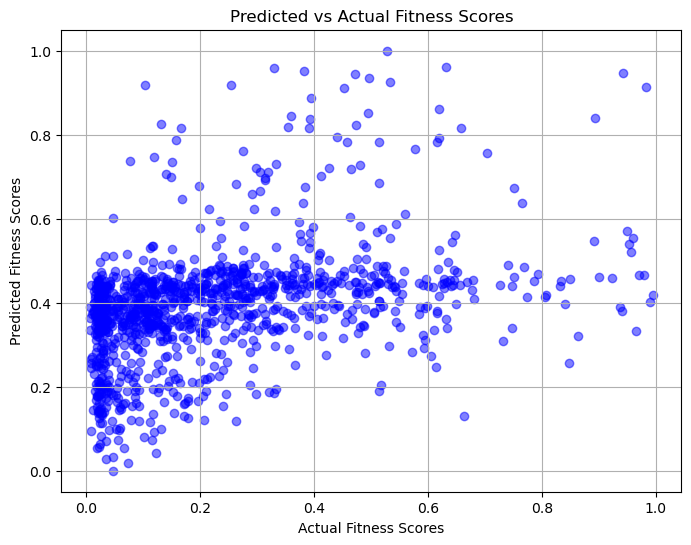

In [21]:
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'actual_values' are your lists of predicted and actual values
# If they're not already available, make sure to collect them as shown in your code above

X, y = get_data(df)

# Ensure the model is in evaluation mode
model.eval()

# Compute predictions
with torch.no_grad():
    predicted_dms_scores = model(X).squeeze().numpy()  # Flatten to 1D array

min_val = np.min(predicted_dms_scores)
max_val = np.max(predicted_dms_scores)
if max_val > min_val:  # Avoid division by zero
    predicted_dms_scores = (predicted_dms_scores - min_val) / (max_val - min_val)
else:
    predicted_dms_scores = np.zeros_like(predicted_dms_scores)  # If all values are the same


# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y, predicted_dms_scores, color='blue', alpha=0.5)
plt.title('Predicted vs Actual Fitness Scores')
plt.xlabel('Actual Fitness Scores')
plt.ylabel('Predicted Fitness Scores')
plt.grid(True)

# Show the plot
plt.show()

In [7]:
df_test = df = pd.read_csv('../test.csv')
df_test.head()

,mutant
0,V1D
1,V1Y
2,V1C
3,V1A
4,V1E


In [8]:
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

In [9]:
sequences = []
for i in df_test['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
df_test['sequence'] = sequences

In [ ]:
#df_test['one_hot_sequence'] = df_test['sequence'].apply(lambda seq: seq_to_one_hot(seq).tolist())
one_hot_sequences = []

# Iterate through each row in the 'sequence' column
for seq in df_test['sequence']:
    one_hot = seq_to_one_hot(seq).tolist()  # Convert to list if needed
    one_hot_sequences.append(one_hot)

# Assign the result to the 'one_hot_sequence' column
df_test['one_hot_sequence'] = one_hot_sequences

In [ ]:
testPred, correlation = compute_predictions_and_spearman(df_test, model)
correlation

In [90]:
# output
df_test["DMS_score_predicted"] = predicted_dms_scores
df_test[["mutant", "DMS_score_predicted"]].to_csv("predictions.csv", index=False)

ValueError: Length of values (1140) does not match length of index (11324)

In [ ]:
top10mutants = df_test.iloc[mean_pred.argsort()[-10:], :]
mutants = []
for mut in top10mutants["mutant"].values:
    mutants.append(mut)

with open("top10.txt", "w") as f:

    f.write("\n".join(mutants))
